# Poisson Tucker versus Dirichlet Tucker model comparison

Here, we evaluate the fit of simplex-constrained Poisson Tucker models to
data generated from a Dirichlet Tucker distribution. We aim to justify the need
for a Dirichlet Tucker distribution.

One concern is that this comparison feels like a bit of a strawman,
since data drawn from a model will naturally be a better fit. However,
we may find a progression of better fit in the Poisson Tucker varianets,
e.g. Poisson Tucker variants with stronger and more "dirichlet-like" constraints
are better fits.

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
from pathlib import Path
import sys

# Add `dtd` virtual environment
VENV_PATH = '/home/users/eyz/.envs/dtd/lib/python3.9/site-packages'

# Add `dirichlet-tucker` repo path. This should not be necessary...but it is
REPO_PATH = os.getcwd().split('/')
i_repo = REPO_PATH.index('dirichlet-tucker')
REPO_PATH = '/'.join(REPO_PATH[:i_repo+1])

for path in [VENV_PATH, REPO_PATH]:
    if path not in sys.path:
        sys.path.insert(0, path)

In [3]:
print(sys.path)

['/home/users/eyz/dirichlet-tucker', '/home/users/eyz/.envs/dtd/lib/python3.9/site-packages', '/home/users/eyz/dirichlet-tucker/analysis', '', '/share/software/user/open/py-pandas/2.0.1_py39/lib/python3.9/site-packages', '/share/software/user/open/py-numpy/1.24.2_py39/lib/python3.9/site-packages', '/share/software/user/open/py-seaborn/0.12.1_py39/lib/python3.9/site-packages', '/share/software/user/open/py-matplotlib/3.4.2_py39/lib/python3.9/site-packages', '/share/software/user/open/py-scipy/1.6.3_py39/lib/python3.9/site-packages', '/share/software/user/open/py-scikit-learn/1.3.2_py39/lib/python3.9/site-packages', '/share/software/user/open/py-jax/0.4.7_py39/lib/python3.9/site-packages', '/share/software/user/open/py-jaxlib/0.4.7_py39/lib/python3.9/site-packages', '/share/software/user/open/py-jupyterlab/4.0.8_py39/lib/python3.9/site-packages', '/share/software/user/open/python/3.9.0/lib/python39.zip', '/share/software/user/open/python/3.9.0/lib/python3.9', '/share/software/user/open/p

In [4]:
import jax
assert jax.__version__ == '0.4.7'

# If importing equinox throws the erorr: <TypeError: unhashable type: 'list'>
# Then ensure that you are using equinox==0.10.5
# Reference: https://github.com/patrick-kidger/equinox/issues/414
import equinox
assert equinox.__version__ == '0.10.5', f"Got {equinox.__version__}"

/home/users/eyz/.envs/dtd/lib/python3.9/site-packages/jaxtyping/__init__.py:210: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


In [6]:
import jax.numpy as jnp
import jax.random as jr
import numpy as onp
import optax
import pandas as pd
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dtd.model3d import (
    DirichletTuckerDecomp
)

from dtd.fit import fit_opt
from dtd.poisson_tucker_3d import (
    ProjectedPoissonTucker,
    L2PenalizedPoissonTucker,
    SimplexPoissonTucker
)

/share/software/user/open/py-scipy/1.6.3_py39/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/users/eyz/.envs/dtd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/users/eyz/.envs/dtd/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Generate data

In [7]:
full_shape = (500, 100, 50)
core_shape = (20, 10, 5)
total_counts = 100

In [8]:
key = jr.PRNGKey(42)
key_true, key_other = jr.split(key)
key_true, key_data, key_mask = jr.split(key_true, 3)

# Instantiate the "true" model and generate observations from it
true_model = DirichletTuckerDecomp(total_counts, *core_shape)
true_params = true_model.sample_params(key_true, *full_shape)
X = true_model.sample_data(key_data, true_params)
X_mask = jr.bernoulli(key_mask, 0.8, shape=full_shape[:-1])

In [9]:
key_proj, key_l2, key_simplex, key_dtd = jr.split(key_other, 4)

# Define objective function
def make_objective_fn(log_prior_weight: float=1):
    def objective_fn(model) -> float:
        """Objective function, differentiate with respect to first argument."""
        lp = jnp.where(X_mask, model.log_likelihood(X), 0.0)
        lp += log_prior_weight * model.log_prior()
        lp /= X_mask.sum()
        return -lp.sum()
    return objective_fn


# L2-penalized Multivariate Tucker

We are interested in comparing the performance of Poisson Tucker and Dirichlet Tucker models.
One thing to be careful about is that these two distributions are define over separate spaces
(i.e. non-negative integers vs. vectors of integers). In order to compare the two model classes,
consider the following sample and Poisson Tucker model:
\begin{align}
x_{mnp} &\sim \textrm{Po}\left(\lambda_{mnp}\right)
\end{align}
where the rate $\lambda_{mnp} = \left[\mathcal{G}; \Psi, \Phi, \Theta\right]_{mnp} \in \mathbb{R}$.

We evaluate the data under this Poisson Tucker model by normalizing the rate
along the event axis and then substituting it into the a Multinomial log probability:
$\mathcal{L}_\textrm{mult}(x_{mnp}) = \log p_{mult}$

In [ ]:
def scaled_poisson_iter_callback(loss, model, data, data_mask):
    # Log likelihood under a Poisson distribution
    ll = model.log_likelihood(data)

    train_ll = (jnp.where(data_mask, ll, 0.0) / data_mask.sum()).sum()
    vldtn_ll = (jnp.where(~data_mask, ll, 0.0) / (~data_mask).sum()).sum()

    # Pseudo log-likelihood under a Multinomial distribution
    # Unscale the rate
    rate = model.reconstruct() # This returns: scale * tucker_reconstruction
    rate /= model.scale

    # Normalize the rate along the event axis (hardcoded to axis=-1)
    rate /= rate.sum(axis=-1, keepdims=True)

    # Evaluate log-likelihood under a Multinomial disribution
    ll_mult = tfd.Multinomial(model.scale, rate).log_prob(X)

    vldtn_ll_mult = jnp.where(~data_mask, ll_mult, 0.0)
    vldtn_ll_mult /= (~data_mask).sum()
    vldtn_ll_mult = vldtn_ll_mult.sum()

    return loss, train_ll, vldtn_ll, vldtn_ll_mult,

In [34]:
# THIS TAKES ~25 minutes to run on CPU, so be careful accidentally re-running
# And of course it takes like 1 min to run on GPU
model_klass = L2PenalizedPoissonTucker
optimizer = optax.adam(1e-2)

n_iters = 1000
n_runs = 5
log_prior_weights = [1, 2.5, 5, 7.5, 10, 25, 50, 100, 500, 1000]

# --------------------------------------------------------------------------
n_conditions = len(log_prior_weights)
l2_model_results_dict = {}

for key_l2_, log_prior_weight in zip(jr.split(key_l2, n_conditions), log_prior_weights):

    objective_fn = make_objective_fn(log_prior_weight)

    all_models, all_train_ll, all_vldtn_ll, all_multi_ll = [], [], [], []
    for i_run, key_ in enumerate(jr.split(key_l2_, n_runs)):
        # Initialize model and optimizer
        model = model_klass.random_init(key_, full_shape, core_shape, total_counts)
        opt_state = optimizer.init(model)

        # Fit with default iter_callback
        (model, _), outputs = fit_opt(model, X, X_mask,
                                      objective_fn,
                                      optimizer, opt_state,
                                      iter_callback=scaled_poisson_iter_callback,
                                      n_iters=n_iters)

        # Save
        all_models.append(model)
        all_train_ll.append(outputs[1])
        all_vldtn_ll.append(outputs[2])
        all_multi_ll.append(outputs[3])
    
    all_train_ll = jnp.stack(all_train_ll)
    all_vldtn_ll = jnp.stack(all_vldtn_ll)
    all_multi_ll = jnp.stack(all_multi_ll)

    l2_model_results_dict[log_prior_weight] = dict(
        model = all_models,
        train_ll = all_train_ll,
        vldtn_ll = all_vldtn_ll,
        multi_ll = all_multi_ll
    )

In [35]:
log_prior_weights = list(l2_model_results_dict.keys())

l2_color_palette = \
    sns.cubehelix_palette(n_colors=len(log_prior_weights), start=2, rot=0,
                          dark=0.1, light=.9, )

l2_color_palette

[[0.8499788704199769, 0.9348975047602627, 0.8670683429450211],
 [0.7219399586739554, 0.8686793588139692, 0.7514705671972318],
 [0.6034657190843836, 0.7964008563055127, 0.642293000661284],
 [0.4990924629125864, 0.7215940533422811, 0.5438698530103805],
 [0.3993317123247641, 0.6374583314730714, 0.4472535653671663],
 [0.3091356338933916, 0.547262253041699, 0.3570574869357938],
 [0.2285042276184688, 0.45100581804816353, 0.2732816177162629],
 [0.16032846418242283, 0.353263601403552, 0.19915574575932327],
 [0.0984105469092495, 0.24514994704926324, 0.12794115543252588],
 [0.046057301792525936, 0.13097593613281167, 0.06314677431757014]]

Text(0.5, 1.0, 'L2PenalizedPoissonTucker vs. regularization strength')

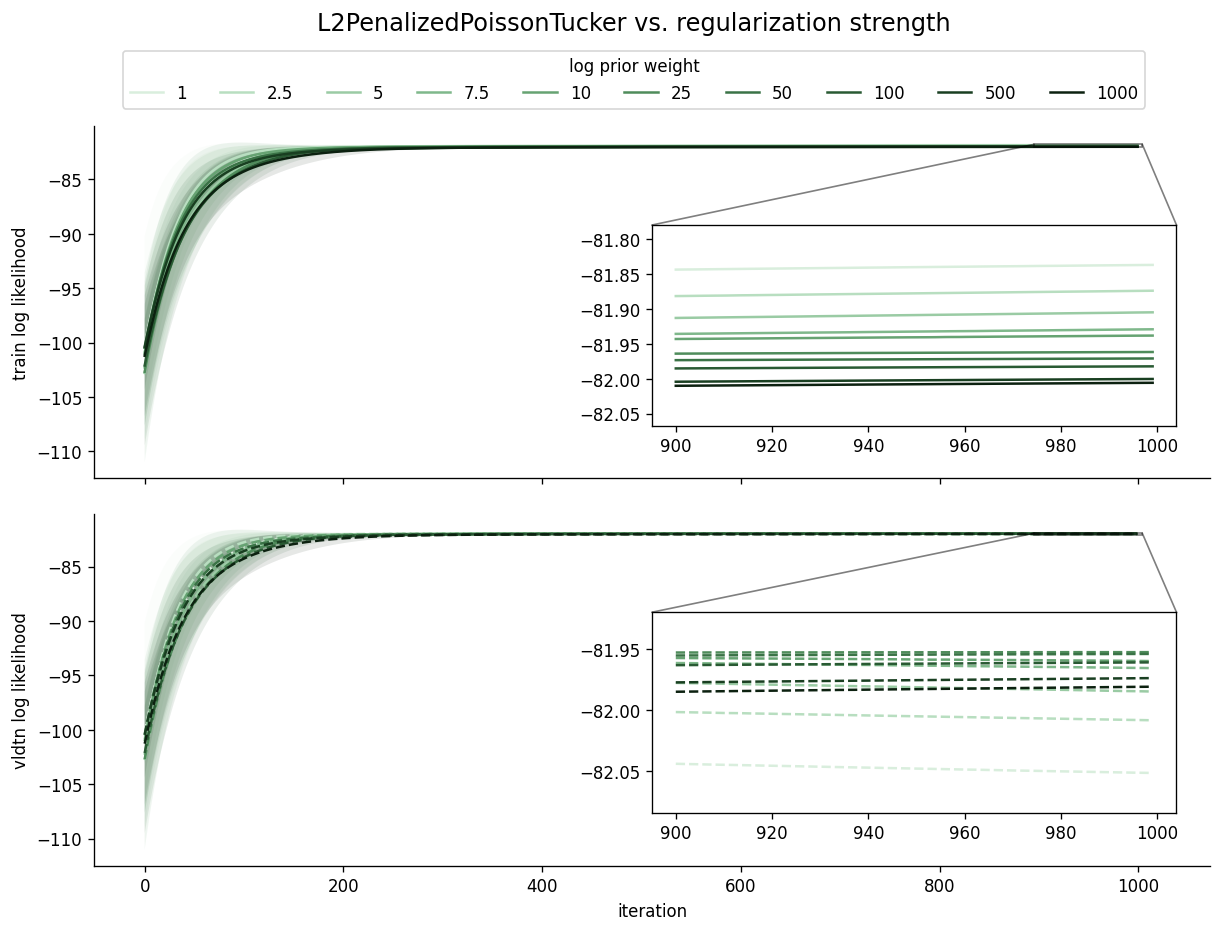

In [36]:
fig, axs = plt.subplots(nrows=2, sharex='col', gridspec_kw={'hspace':0.1},
                        figsize=(12,8), dpi=120)

inset_idxs = jnp.arange(n_iters-100, n_iters)

for i_row, (ll_type, ls) in enumerate([('train_ll', '-'), ('vldtn_ll', '--')]):
    ax_main = axs[i_row]
    ax_inset = ax_main.inset_axes([0.5, 0.15, 0.47, 0.57],)

    for i_weight, (weight, results) in enumerate(l2_model_results_dict.items()):
        # c_weight = l2_color_palette(l2_color_norm(weight))
        c_weight = l2_color_palette[i_weight]

        ll = results[ll_type]
        ll_mean = jnp.mean(ll, axis=0)
        ll_std = jnp.std(ll, axis=0)
        
        ax_main.plot(jnp.arange(n_iters), ll_mean, c=c_weight, ls=ls)
        ax_main.fill_between(jnp.arange(n_iters),
                            ll_mean-2*ll_std, ll_mean+2*ll_std,
                            fc=c_weight, alpha=0.1)
        
        ax_inset.plot(inset_idxs, ll_mean[inset_idxs], c=c_weight, ls=ls)
        ax_main.fill_between(inset_idxs,
                            (ll_mean-ll_std)[inset_idxs],
                            (ll_mean+ll_std)[inset_idxs],
                            fc=c_weight, alpha=0.1)
        
    # Increase inset margins
    ax_inset.margins(y=0.33)

    # Indicate inset
    ax_main.indicate_inset_zoom(ax_inset, edgecolor='black')

    # Make pretty
    ax_main.set_ylabel(f"{ll_type.split('_')[0]} log likelihood")
    sns.despine(ax=ax_main)

axs[-1].set_xlabel('iteration')

# Add legend
handles = [
    mpl.lines.Line2D([0],[0], c=l2_color_palette[i_weight], label=f'{weight}')
    for i_weight, weight in enumerate(log_prior_weights)
]

# fig.legend(handles=handles, loc='center left', bbox_to_anchor=[0.92,0.5],
#            title='log prior weight')

fig.legend(handles=handles, loc='lower center', bbox_to_anchor=[0.5, 0.89],
           ncol=len(handles), title='log prior weight')

fig.suptitle(f'{model_klass.__name__} vs. regularization strength', fontsize='x-large', y=1.0)

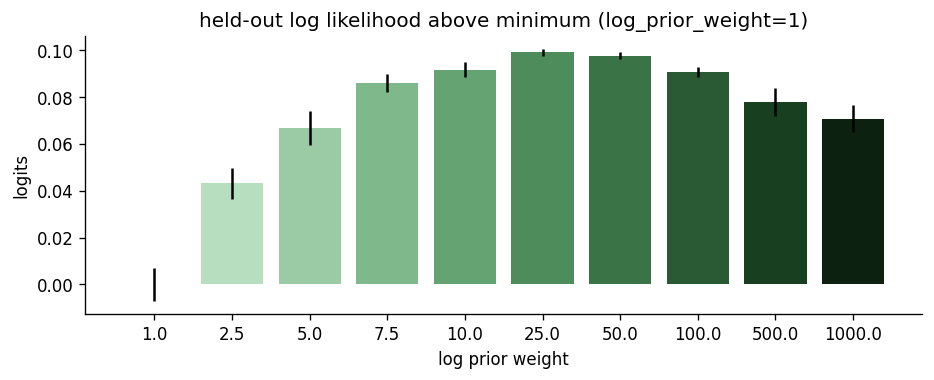

In [37]:
fig, ax = plt.subplots(figsize=(9,3), dpi=120)

ll_means = onp.array([
    onp.mean(results['vldtn_ll'][:,-1]) for results in l2_model_results_dict.values()
])
ll_stds = onp.array([
    onp.std(results['vldtn_ll'][:,-1]) for results in l2_model_results_dict.values()
])

i_weights = onp.arange(len(log_prior_weights))
rects = ax.bar(i_weights, ll_means-onp.min(ll_means), yerr=ll_stds,
               color=l2_color_palette,
               tick_label=log_prior_weights)
ax.set_xlabel('log prior weight')
ax.set_ylabel('logits')
ax.set_title("held-out log likelihood above minimum "
             f"(log_prior_weight={log_prior_weights[onp.argmin(ll_means)]})")
sns.despine(ax=ax)

# Simplex Constrained Tucker and Projected Tucker

In [38]:
model_klasses = [
    ProjectedPoissonTucker,
    L2PenalizedPoissonTucker,
    SimplexPoissonTucker,
]

model_color_palette = [
    (0.4740506835842468, 0.4841158085995784, 0.6737939274369329), # lavender
    (0.3091356338933916, 0.547262253041699, 0.3570574869357938), # green# (0.18653861642264968, 0.3669177984726364, 0.2326906286124265), # forest green
    (0.4169601093967653, 0.5972734482832117, 0.6503651312175652), # slate blue,
    (0.43082755198027817, 0.24984535814964698, 0.44393960899639856), # magenta
]

In [63]:
from copy import deepcopy
model_results_dict = {
    'ProjectedPoissonTucker': {},
    'L2PenalizedPoissonTucker': deepcopy(l2_model_results_dict[25]),
    'SimplexPoissonTucker': {},
}

In [64]:
# Initialize model and optimizer
optimizer = optax.adam(1e-2)

n_iters = 1000
n_runs = 5

for model_klass in [ProjectedPoissonTucker, SimplexPoissonTucker]:
    all_models, all_train_ll, all_vldtn_ll, all_multi_ll = [], [], [], []
    for i, key_ in enumerate(jr.split(key_simplex, n_runs)):
    
        objective_fn = make_objective_fn(1)
    
        model = model_klass.random_init(key_, full_shape, core_shape, total_counts)
        opt_state = optimizer.init(model)
    
        # Fit with default iter_callback
        (model, _), outputs = fit_opt(model, X, X_mask,
                                      objective_fn,
                                      optimizer, opt_state,
                                      iter_callback=scaled_poisson_iter_callback,
                                      n_iters=n_iters)
    
        all_models.append(model)
        all_train_ll.append(outputs[1])
        all_vldtn_ll.append(outputs[2])
        all_multi_ll.append(outputs[3])
    
    model_results_dict[model_klass.__name__] = dict(
        model = all_models,
        train_ll = jnp.stack(all_train_ll),
        vldtn_ll = jnp.stack(all_vldtn_ll),
        multi_ll = jnp.stack(all_multi_ll),
    )

## Fit DTD

In [66]:
model_results_dict['DirichletTuckerDecomp'] = {}

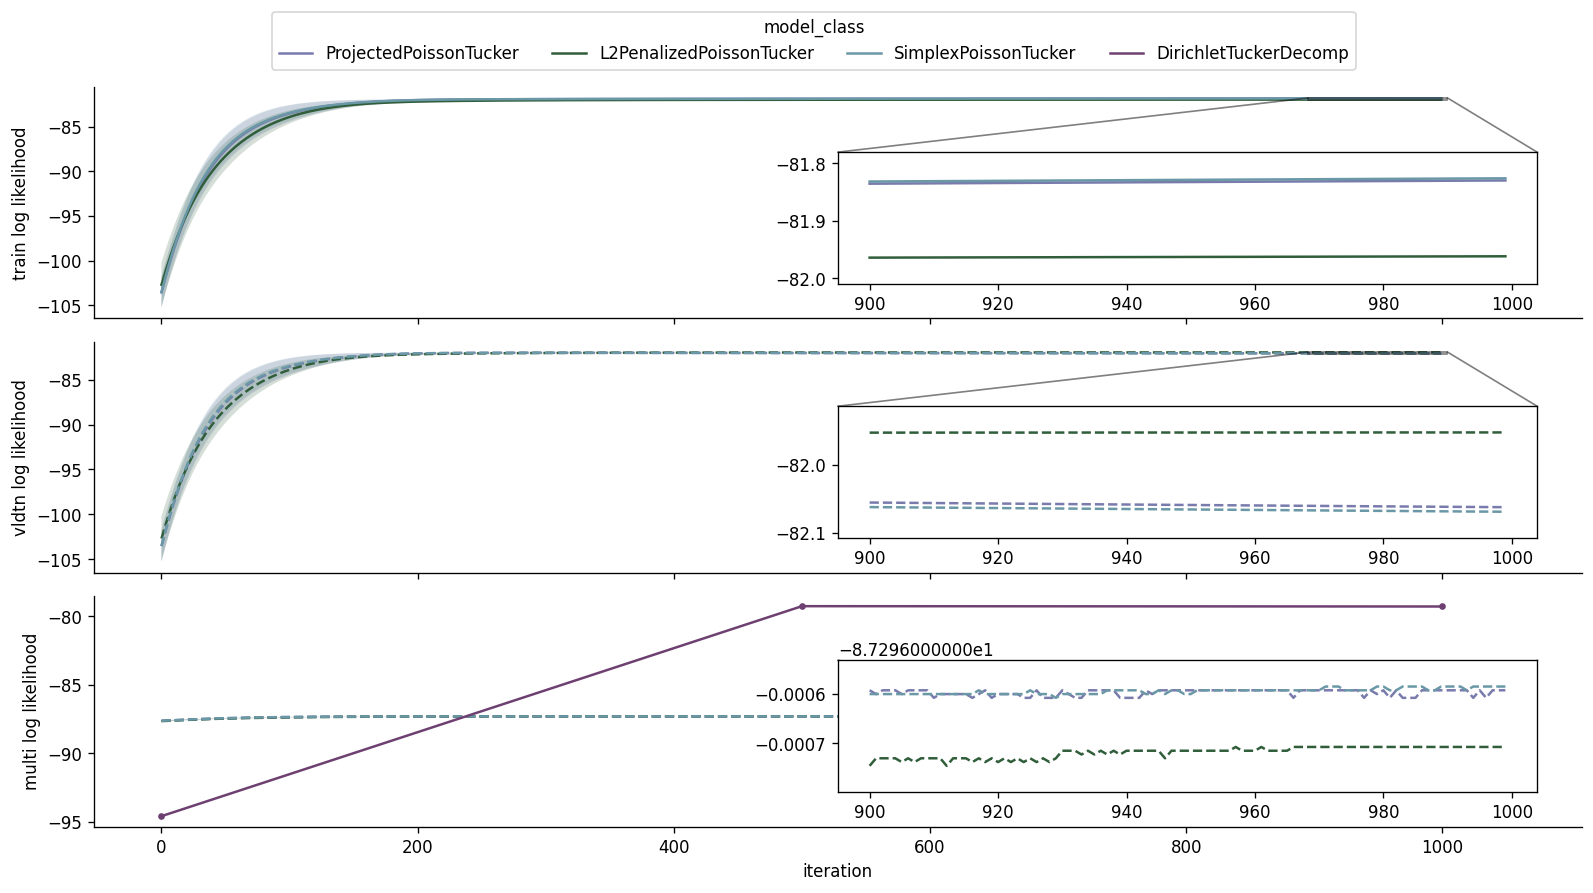

In [75]:
fig, axs = plt.subplots(nrows=3, sharex='col', gridspec_kw={'hspace':0.1},
                        figsize=(16,8), dpi=120)

inset_idxs = jnp.arange(n_iters-100, n_iters)

for i_row, (ll_type, ls) in enumerate([('train_ll', '-'), ('vldtn_ll', '--'), ('multi_ll', '--')]):
    ax_main = axs[i_row]
    ax_inset = ax_main.inset_axes([0.5, 0.15, 0.47, 0.57],)

    for i_model, (model_name, model_results) in enumerate(model_results_dict.items()):
        
        # ======================================================================
        # HACK
        # ----------------------------------------------------------------------
        if model_name == 'DirichletTuckerDecomp':
            continue
        # ======================================================================

        c_model = model_color_palette[i_model]

        ll = model_results[ll_type]
        ll_mean = jnp.mean(ll, axis=0)
        ll_std = jnp.std(ll, axis=0)
        
        ax_main.plot(jnp.arange(n_iters), ll_mean, c=c_model, ls=ls)
        ax_main.fill_between(jnp.arange(n_iters), ll_mean-ll_std, ll_mean+ll_std,
                            fc=c_model, alpha=0.2)
        
        ax_inset.plot(inset_idxs, ll_mean[inset_idxs], c=c_model, ls=ls)
        ax_main.fill_between(inset_idxs,
                            (ll_mean-ll_std)[inset_idxs],
                            (ll_mean+ll_std)[inset_idxs],
                            fc=c_model, alpha=0.1)
        
        sns.despine(ax=ax_main)

    # Increase inset margins
    ax_inset.margins(y=0.33)

    # Indicate inset
    ax_main.indicate_inset_zoom(ax_inset, edgecolor='black')

    ax_main.set_ylabel(f"{ll_type.split('_')[0]} log likelihood")
    sns.despine(ax=ax_main)

# =============================================================================
# HACK
# -----------------------------------------------------------------------------
dtd_vldtn_lls = onp.array([-94.57932, -79.257965, -79.28222])
dtd_vldtn_iters = onp.array([0, 500, 1000])

axs[-1].plot(dtd_vldtn_iters, dtd_vldtn_lls, marker='.', color=model_color_palette[-1])

# =============================================================================

axs[-1].set_xlabel('iteration')
# Add legend
handles = [
    mpl.lines.Line2D([0],[0], c=model_color_palette[i_weight], label=f'{weight}')
    for i_weight, weight in enumerate(model_results_dict.keys())
]

fig.legend(handles=handles, loc='lower center', bbox_to_anchor=[0.5, 0.89],
           ncol=len(handles), title='model_class')


# fig.suptitle(f'{model_klass.__name__}', fontsize='x-large')

# Dirichlet Tucker

In [ ]:
dtd_vldtn_lls = onp.array([-94.57932, -79.257965, -79.28222])
dtd_vldtn_iters = onp.array([0, 500, 100])

In [225]:
model = DirichletTuckerDecomp(total_counts, *core_shape)
init_params = model.sample_params(key_dtd, *full_shape)

params, lps = model.fit(X, X_mask, init_params, 1000)

  0%|          | 0/500 [00:00<?, ?it/s]